In [40]:
#standards
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#metaknowledge to handle citation-data:
import metaknowledge as mk

#to build force-atlas networks:
import networkx as nx
from fa2 import ForceAtlas2
import community
from sklearn.cluster import SpectralClustering

#umap, etc.:
import umap
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import scipy as scipy
from scipy.sparse import coo_matrix, vstack
from scipy.sparse import csr_matrix
import re

%load_ext rpy2.ipython


#data

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [48]:
def create_network(record_collection):
    "This creates a citation network of the entered data and lays it out with the common force-atlas algorithm."
    citations = RC.networkCitation(directed=False,nodeType = "full",fullInfo=True,nodeInfo=True,detailedCore=True,coreOnly=True)

    citations = max(nx.connected_component_subgraphs(citations), key=len)
    
    adj_mat = nx.to_numpy_matrix(citations)
    sc = SpectralClustering(8, affinity='precomputed', n_init=100, assign_labels='discretize')
    sc.fit(adj_mat)
    labels= sc.labels_.tolist()



    forceatlas2 = ForceAtlas2(scalingRatio=10.0,strongGravityMode=True,verbose=False)
    positions = forceatlas2.forceatlas2_networkx_layout(citations, pos=None, iterations=200)
    return(citations, positions,labels)

In [100]:
def create_umap(record_collection):
    d = []
    e = []
    for R in RC:
        d.append(list(set(R.getCitations().get("citeString")))) #To cluster by cited author
        authors = list(set(R.getCitations().get("author")))
        authors = filter(None, authors)
        f = []
        for a in authors:
            f.append(' '.join([w for w in a.split(' ')if len(w)>2]))        
        authors = f#' '.join(f)
        e.append(authors)

    worklist = ['§'.join(filter(None,x)) for x in list(d)]
    authorslist = [';'.join(filter(None,x)) for x in list(e)] 

    vec = TfidfVectorizer(token_pattern=r'(?<=[^|§])[\s\w,\.:;]+(?=[$|§])')
    Xrc = vec.fit_transform(worklist)

    vecAu = CountVectorizer(token_pattern=r'(?<=[;])[\s\w]+(?=[;])',binary=True, min_df = 10)
    XrcAu = vecAu.fit_transform(authorslist)

    k = [Xrc]#XrcAu,
    XrcFull = scipy.sparse.hstack(k).tocsr()



    a = 0
    # index by name:
    for x in range(0,XrcFull.shape[0]): #Xrc.shape[0]):
        if np.diff(XrcFull[x].tocsr().indptr) >= 4:
            if a == 0:
                k = [XrcFull[x]]
            if a != 0:
                k.append(XrcFull[x])
            a = a+1

    M = scipy.sparse.vstack((k))
    SVD = TruncatedSVD(n_components=145, n_iter=7, random_state=42)

    XSVD = SVD.fit_transform(M)
    embedding = umap.UMAP(n_neighbors = 33,#small => local, large => global: 5-50
                          min_dist = 0.005, #small => local, large => global: 0.001-0.5
                          n_epochs = 700,
                          init='random',
                          spread = 2,
                          metric='cosine').fit_transform(XSVD)
    embedding = pd.DataFrame(embedding)
    embedding.columns = ['x','y']
    return(embedding)

In [ ]:
def create_umap_from_graph(citations):
    "Creates a umap embedding from the adjactency matrix of a graph"
    M = nx.to_numpy_matrix(citations)
    SVD = TruncatedSVD(n_components=145, n_iter=7, random_state=42)
    M = SVD.fit_transform(M)
    embedding = umap.UMAP(n_neighbors = 17,#small => local, large => global: 5-50
                          min_dist = 0.005, #small => local, large => global: 0.001-0.5
                          n_epochs = 700,
                          init='random',
                          spread = 2,
                          metric='cosine').fit_transform(M)
    
    embedding_adj = pd.DataFrame(embedding)
    embedding_adj.columns = ['x','y']
    return(embedding_adj)

C:\Users\user\Anaconda3\lib\site-packages\umap_learn-0.3.3-py3.6.egg\umap\umap_.py:1031: RuntimeWarning: divide by zero encountered in power


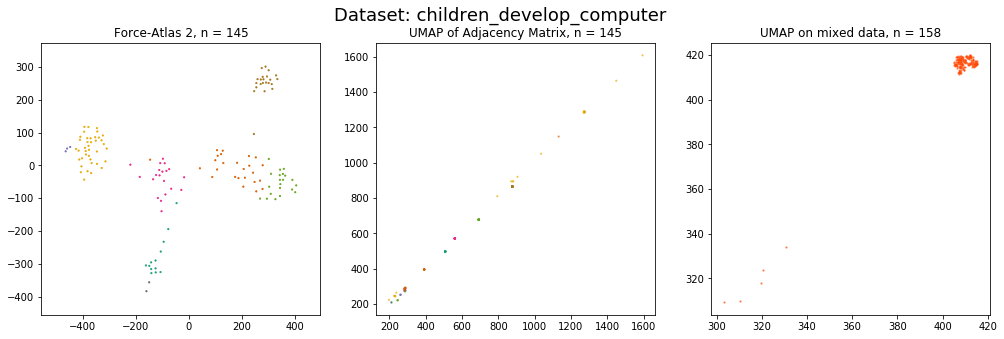

In [ ]:
record_collections = ["children_develop_computer","phil_of_emotions","theory_of_science","general_philosophy"]#"theory_of_science", "general_philosophy" 
for collection in record_collections:
    RC = mk.RecordCollection(collection)
    citations, positions, labels = create_network(RC)
    embedding = create_umap(RC)
    embedding_adj = create_umap_from_graph(citations)


    plt.figure(figsize=(17,5))    #node_color='orange',
    plt.suptitle(str("Dataset: "+collection), fontsize=18)
    plt.subplot(1, 3, 1)
    nx.draw_networkx(citations, positions,  
                     cmap=plt.cm.get_cmap('Dark2',8),
                     node_color=labels,
                     with_labels=False,  node_size=2, edge_color='white',
                     linewidths=0.7, font_size=8)
    plt.title(str("Force-Atlas 2, n = "+str(citations.number_of_nodes())))
    plt.subplot(1, 3, 2)
    plt.scatter(embedding_adj['x'], embedding_adj['y'],
                cmap=plt.cm.get_cmap('Dark2',8),
                c=labels,s=1.7, alpha=0.5)
    plt.title(str("UMAP of Adjacency Matrix, n = "+str(citations.number_of_nodes())))
    plt.subplot(1, 3, 3)
    plt.scatter(embedding['x'], embedding['y'], c='orangered',s=1.7, alpha=0.5)
    plt.title(str("UMAP on mixed data, n = "+str(len(embedding))))
    plt.show()